1. Скачать датасет   https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
2. Написать "сиамскую" нейросеть
3. *Используя BCELoss обучить нейронку кодировать изображения одного человека (одного класса) похожим образом
4. С помощью t-SNE визуализировать результаты работы (использовать тестовый датасет)
5. Визуализировать результаты работы (inference) в виде - пара изображений + distance
6. Вместо BCELoss использовать "Contrastive loss function", сравнить результаты

In [ ]:
import os
import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [2]:
class PairDataset(Dataset):
    def __init__(self, image_folders, transform=None, train=True):
        self.image_folders = image_folders
        self.transform = transform
        self.train = train

        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        for folder in self.image_folders:
            images = os.listdir(folder)
            if self.train:

                train_images = images[:7]

                for img1 in range(len(train_images)):
                    for img2 in range(img1+1, len(train_images)):
                        pairs.append((os.path.join(folder, train_images[img1]), 
                                      os.path.join(folder, train_images[img2]), 1))

                for img1 in range(len(train_images)):
                    other_folder = random.choice(self.image_folders)
                    if other_folder != folder:
                        other_image = random.choice(os.listdir(other_folder))
                        pairs.append((os.path.join(folder, train_images[img1]), 
                                      os.path.join(other_folder, other_image), 0))
            else:

                test_images = images[7:]

                for img1 in range(len(test_images)):
                    for img2 in range(img1+1, len(test_images)):
                        pairs.append((os.path.join(folder, test_images[img1]), 
                                      os.path.join(folder, test_images[img2]), 1))

                    other_folder = random.choice(self.image_folders)
                    if other_folder != folder:
                        other_image = random.choice(os.listdir(other_folder))
                        pairs.append((os.path.join(folder, test_images[img1]), 
                                      os.path.join(other_folder, other_image), 0))
        return pairs

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

    def __len__(self):
        return len(self.pairs)


In [3]:
# normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((224, 224)),                 
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5], std=[0.5])    
])


image_folders = [f"dataset/s{folder}" for folder in range (1,41)]

train_dataset = PairDataset(image_folders=image_folders, transform=transform, train=True)
test_dataset = PairDataset(image_folders=image_folders, transform=transform, train=False)

train_loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, pin_memory_device='cuda')
test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, pin_memory_device='cuda')

print (len(train_dataset))
print (len(train_loader))

print (len(test_dataset))
print (len(test_loader))

img1, img2, labels = next(iter(train_loader))
print (img1.shape, img2.shape, labels.shape)

1111
1111
237
237
torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1])


In [4]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.lrn1 = nn.LocalResponseNorm(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.lrn2 = nn.LocalResponseNorm(128)
        self.fc1 = nn.Linear(128 * 56 * 56, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.pool(x)
        x = nn.ReLU()(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(x.size(0), -1)  
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        cosine_similarity = nn.functional.cosine_similarity(output1, output2)
        
        loss = torch.mean((label) - cosine_similarity).abs() + torch.mean((self.margin - cosine_similarity) - (1 - label)).abs()
        return loss


In [6]:
def train_contrastive_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SiameseNet()
    model = model.to(device)

    print (torch.cuda.is_available())

    criterion = ContrastiveLoss(margin=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.4)

    num_epochs = 5
    overall_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img1, img2, labels in train_loader:
            # print (img1.shape)
            
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()

            output1, output2 = (model(img1), model(img2))

            loss = criterion(output1, output2, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            for img1, img2, labels in test_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                output1, output2 = model(img1), model(img2)
                cosine_similarity = nn.functional.cosine_similarity(output1, output2)
                probability = torch.sigmoid(cosine_similarity)
                if probability.float() <= 0.7 and labels == 0: correct += 1
                if probability.float() > 0.7 and labels == 1: correct += 1
                total += 1
            accuracy = correct/total
            overall_accuracy += accuracy
        
        print(f"Accuracy: {accuracy*100:.4f}%")
        
    print(f"Overall Accuracy: {(overall_accuracy/num_epochs)*100:.4f}%") # ~90%

    torch.save(model, 'siamese_model_full_contrastive.pth')
    print("Model saved to: siamese_model_full_contrastive.pth")
    return (model)

In [7]:
def train_BCE_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SiameseNet()
    model = model.to(device)

    print (torch.cuda.is_available())

    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.4)

    num_epochs = 5
    overall_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img1, img2, labels in train_loader:
            
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()

            output1, output2 = model(img1), model(img2)
            cosine_similarity = nn.functional.cosine_similarity(output1, output2)

            probability = torch.sigmoid(cosine_similarity)

            loss = criterion(probability, labels.float())
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            for img1, img2, labels in test_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

                output1, output2 = model(img1), model(img2)
                cosine_similarity = nn.functional.cosine_similarity(output1, output2)
                probability = torch.sigmoid(cosine_similarity)
                # print (probability.float())
                # print (labels)
                if probability.float() <= 0.7 and labels == 0: correct += 1
                if probability.float() > 0.7 and labels == 1: correct += 1
                total += 1
            accuracy = correct/total
            overall_accuracy += accuracy
        
        print(f"Accuracy: {accuracy*100:.4f}%")
        
    print(f"Overall Accuracy: {overall_accuracy/num_epochs*100:.4f}%") # ~80%
        
    torch.save(model, 'siamese_model_full_BCE.pth')
    print("Model saved to: siamese_model_full_BCE.pth")
    return (model)

In [ ]:
# Uncomment lines below if not trained
# contrastive_model = train_contrastive_model()

True
Epoch 1/5, Loss: 0.4063
Accuracy: 84.3882%
Epoch 2/5, Loss: 0.3110
Accuracy: 84.8101%
Epoch 3/5, Loss: 0.2594
Accuracy: 91.5612%
Epoch 4/5, Loss: 0.2200
Accuracy: 92.8270%
Epoch 5/5, Loss: 0.1803
Accuracy: 95.3586%
Overall Accuracy: 89.7890%
Model saved to: siamese_model_full_contrastive.pth


In [ ]:
# BCE_model = train_BCE_model()

True
Epoch 1/5, Loss: 0.4808
Accuracy: 86.9198%
Epoch 2/5, Loss: 0.4330
Accuracy: 91.1392%
Epoch 3/5, Loss: 0.4157
Accuracy: 89.4515%
Epoch 4/5, Loss: 0.4092
Accuracy: 87.3418%
Epoch 5/5, Loss: 0.4027
Accuracy: 87.3418%
Overall Accuracy: 88.4388%
Model saved to: siamese_model_full_BCE.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_TSNE_dataset ():
    data = []
    for image_folder in image_folders:
        folder_data = []
        images = os.listdir(image_folder)
        for img in images:
            image_data = Image.open(os.path.join(image_folder, img)).convert("RGB")
            image_data = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                             transforms.Resize((224, 224)),                 
                                             transforms.ToTensor(),                        
                                             transforms.Normalize(mean=[0.5], std=[0.5])])(image_data)
            image_data = image_data.unsqueeze(1)
            # print(image_data.shape)
            folder_data.append(image_data)
        data.append(folder_data)
    return data


def get_TSNE (used_model, test_data):
    results = []
    color = []
    folder_idx = 0
    for folder in test_data:
        folder_idx += 1
        for image in folder:
            image = image.to(device)
            result = used_model(image)
            result = result.to(torch.device('cpu')).detach().numpy()
            # print (result.shape)
            results.append(result)
            color.append(folder_idx/40*255)

    results = np.array(results).squeeze(1)
    visual = TSNE().fit_transform(results)
    visual = visual.reshape((2,400))
    # print (visual.shape)
    plt.scatter(visual[0], visual[1], c=color, alpha = 0.8)
    plt.show

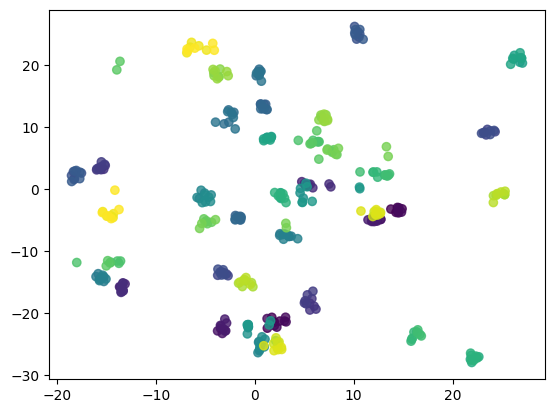

In [27]:
model_contrastive = torch.load('siamese_model_full_contrastive.pth', weights_only = False)
model_contrastive.eval()

test_data = get_TSNE_dataset ()
# print(test_data[0][0].shape)
get_TSNE (used_model=model_contrastive, test_data=test_data)

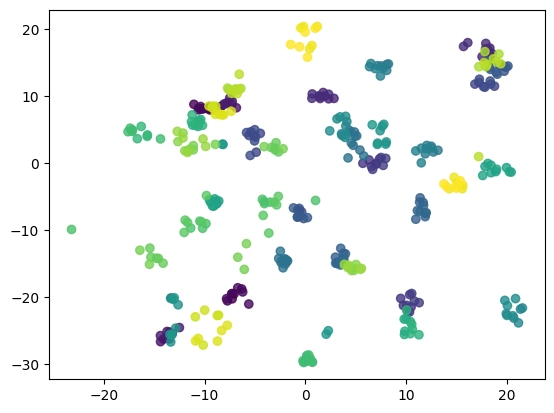

In [28]:
model_BCE = torch.load('siamese_model_full_BCE.pth', weights_only = False)
model_BCE.eval()

test_data = get_TSNE_dataset ()
# print(test_data[0][0].shape)
get_TSNE (used_model=model_BCE, test_data=test_data)

In [37]:
def get_inference_dataset():
    pairs = []
    used_image_folders = np.random.choice(image_folders, size=random.randint(6,10), replace=False)

    for image_folder in used_image_folders:
        image = random.choice(os.listdir(image_folder))
        plt_image = Image.open(os.path.join(image_folder, image)).convert("RGB")
        image = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                    transforms.Resize((224, 224)),                 
                                    transforms.ToTensor(),                        
                                    transforms.Normalize(mean=[0.5], std=[0.5])])(plt_image)
        image = image.unsqueeze(1)
        
        other_folder = random.choice(used_image_folders)
        other_image = random.choice(os.listdir(other_folder))
        plt_other_image = Image.open(os.path.join(other_folder, other_image)).convert("RGB")
        other_image = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                          transforms.Resize((224, 224)),                 
                                          transforms.ToTensor(),                        
                                          transforms.Normalize(mean=[0.5], std=[0.5])])(plt_other_image)
        other_image = other_image.unsqueeze(1)

        if other_folder != image_folder:
            # print (image_folder)
            # print (other_folder)
            pairs.append((plt_image, plt_other_image,
                          image, other_image, 0))
        else:
            pairs.append((plt_image, plt_other_image,
                          image, other_image, 1))
            
    return pairs


def get_inference(used_model, test_data):
    fig, axes = plt.subplots(nrows=(len(test_data)), ncols=2, figsize=(5, 15))
    axes = axes.flatten()
    
    total = 0
    correct = 0

    with torch.no_grad():
        used_model.eval()
        for i, (img_out1, img_out2, img1, img2, label) in enumerate(test_data):

            axes[2*i].imshow(img_out1)
            axes[2*i].axis('off') 

            axes[2*i + 1].imshow(img_out2)
            axes[2*i + 1].axis('off')

            img1, img2 = img1.to(device), img2.to(device)
            output1 = used_model(img1)
            output2 = used_model(img2)
            # print(output1.shape)
            cosine_similarity = nn.functional.cosine_similarity(output1, output2)
            probability = torch.sigmoid(cosine_similarity)
            result = probability.to('cpu').detach().numpy()[0]
            # print (result)
            caption = f"Pair {i+1}: similarity={result} label={label}"
            axes[2*i].set_title(caption, fontsize=10, ha='left', pad=10)

            
            if probability.float() <= 0.7 and label == 0: correct += 1
            if probability.float() > 0.7 and label == 1: correct += 1
            total += 1
            
    print(f"Accuracy: {correct/total*100:.4f}%")
    
    plt.tight_layout()
    plt.show()

Contrastive loss version results:
Accuracy: 100.0000%


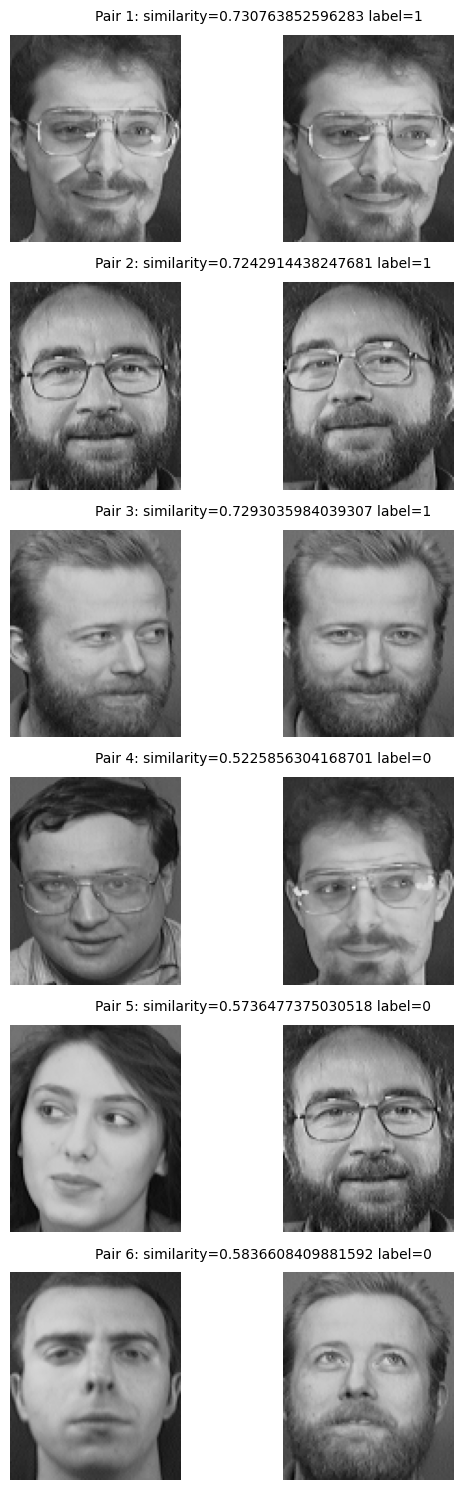

In [38]:
inference_data = get_inference_dataset()

print ("Contrastive loss version results:")
get_inference(used_model=model_contrastive, test_data=inference_data)

BCE loss version results:
Accuracy: 100.0000%


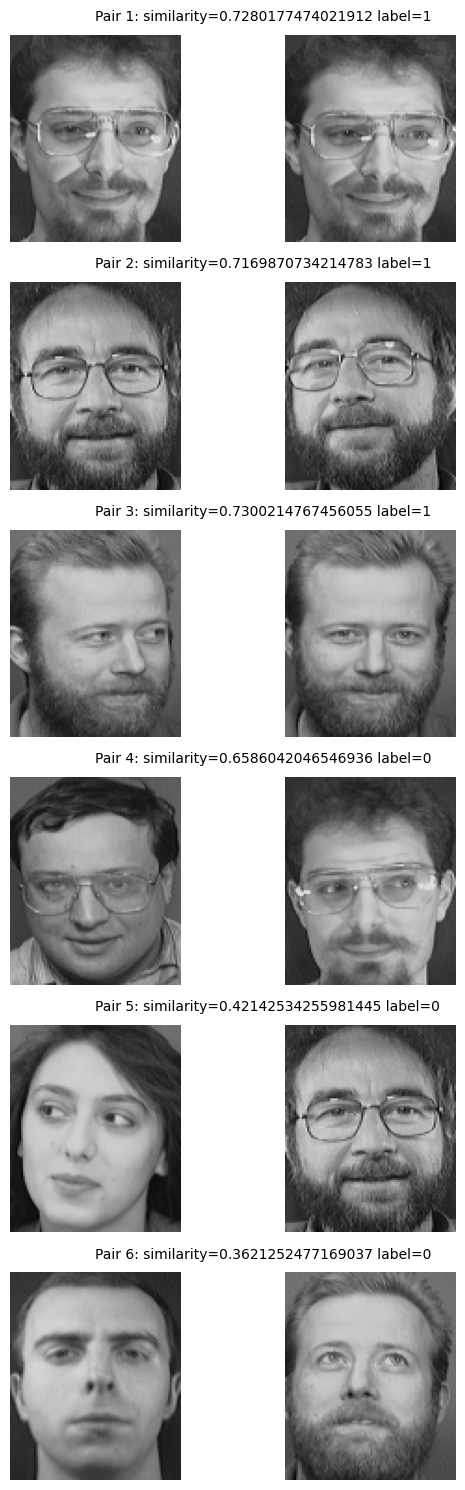

In [39]:
print ("BCE loss version results:")
get_inference(used_model=model_BCE, test_data=inference_data)